In [6]:
# import libraries
import os
import random
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns   


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
import sklearn.model_selection as model_selection

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [4]:
#Import data

#Get metadata
metadata=pd.read_csv('../data/musicnet_metadata.csv')

# Get consolidated saved csvs of WAV Spectral features only
train_wav = pd.read_csv('../data/df_train_wav_consolidated.csv',index_col=0)
test_wav = pd.read_csv('../data/df_test_wav_finc.csv',index_col=0)

#Get midi features only
midi_features = pd.read_csv('../data/midi_features.csv',index_col=0)
#Create X and y for Wav Data for Spectral Features only

#Make a copy of the metadata
meta_data_copy = metadata.copy(deep=True)
meta_data_copy.reset_index(inplace=True)

#Rename column name
meta_data_copy = meta_data_copy.rename(columns = {'id':'filename'})

#Merge Metadata and Wav Data Only
merged_train_data_w = pd.merge(train_wav , meta_data_copy , on="filename")
merged_train_data_w = merged_train_data_w.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index"], axis=1)

merged_test_data_w = pd.merge(test_wav , meta_data_copy , on="filename")
merged_test_data_w = merged_test_data_w.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index"], axis=1)

#Checked that unique ensembles in test are a subset of train
#Get list of unique ensembles
ens_list = merged_train_data_w['ensemble'].unique()

#Map list of unique ensemble names to integer
mapping = {item:i for i, item in enumerate(ens_list)}
merged_train_data_w["ensemble"] = merged_train_data_w["ensemble"].apply(lambda x: mapping[x])
merged_test_data_w["ensemble"] = merged_test_data_w["ensemble"].apply(lambda x: mapping[x])

#This is the original train test split given in kaggle. 
#The code is selecting only the ensemble for the y and letting the rest of the features be in X

X_original_train = merged_train_data_w.iloc[:,np.r_[:167,168]]
X_original_test = merged_test_data_w.iloc[:,np.r_[:167,168]]

y_original_train = merged_train_data_w.iloc[:,167:168]
y_original_test = merged_test_data_w.iloc[:,167:168]

#Concatenate the training and test data
x_frames = [X_original_train,X_original_test]
X_wav = pd.concat(x_frames , ignore_index=True)

y_frames = [y_original_train,y_original_test]
y_wav = pd.concat(y_frames , ignore_index=True)

#Find the index position of viola quintet and drop it since there is only one ensemble of that type
index_violaquintet_wav_only = y_wav[ y_wav['ensemble'] == 3 ].index
y_wav.drop(index_violaquintet_wav_only , inplace=True)
X_wav.drop(index_violaquintet_wav_only , inplace=True)

#This is the train test split for Spectral Wav Data only
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True) 
#Create X and y for Granular MIDI Data Attributes only

#Make a copy of the midi features
midi_features_copy = midi_features.copy(deep=True)
midi_features_copy.reset_index(inplace=True)

#Rename column name in both the copy and the original
midi_features_copy = midi_features_copy.rename(columns = {'file_name':'filename'})
midi_features = midi_features.rename(columns = {'file_name':'filename'})


#Merge Metadata and MIDI Data only

#For original midi
merged_midi_data = pd.merge(midi_features , meta_data_copy , on="filename")
merged_midi_data = merged_midi_data.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index"], axis=1)

#For midi copy
merged_midi_data_copy = pd.merge(midi_features_copy , meta_data_copy , on="filename")
merged_midi_data_copy = merged_midi_data_copy.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index_x"], axis=1)

#Map list of unique ensemble names to integer

#For original midi
merged_midi_data["ensemble"] = merged_midi_data["ensemble"].apply(lambda x: mapping[x])

#For midi copy
merged_midi_data_copy["ensemble"] = merged_midi_data_copy["ensemble"].apply(lambda x: mapping[x])

#To select data for train and test for midi based on the same splits done for wav based on multiple conditions you can use &:
#Removes file name as a feature and also removes viola quintet
midi_train = merged_midi_data.loc[merged_midi_data['filename'].isin(filenames_in_train)]
X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

midi_test = merged_midi_data.loc[merged_midi_data['filename'].isin(filenames_in_test)]
X_test_m = midi_test.iloc[:,np.r_[1:10,11]]
y_test_m = midi_test.iloc[:,np.r_[10]]

# Create Dataset with MIDI and WAV Spectral Data

#Drop duplicate columns
merged_midi_data_copy.drop(['seconds','index_y'],axis=1,inplace=True) 

#Find the index position of viola quintet and drop it since there is only one ensemble of that type
index_violaquintet_midi_only = merged_midi_data_copy[ merged_midi_data_copy['ensemble'] == 3 ].index
merged_midi_data_copy.drop(index_violaquintet_midi_only , inplace=True)

#Merge Midi and Wav Data 
merged_data_c = pd.merge(X_wav, merged_midi_data_copy , on="filename")

#To select data for train and test for midi based on the same splits done for wav based on multiple conditions you can use &:
#Removes file name as a feature and also removes viola quintet
comb_train = merged_data_c.loc[merged_data_c['filename'].isin(filenames_in_train)]
X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]

comb_test = merged_data_c.loc[merged_data_c['filename'].isin(filenames_in_test)]
X_test_c = comb_test.iloc[:,np.r_[0,2:177]]
y_test_c = comb_test.iloc[:,np.r_[177]]

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


C:\Users\David.Ristau\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:
X_test_c

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,seconds,midi_nunique_inst,midi_nunique_note,midi_num_notes,midi_min_note,midi_second_quintile_note,midi_median_note,midi_fourth_quintile_note,midi_max_note,midi_avg_notes_inst
3,0,-336.124298,151.521805,-6.498520,25.719015,1.903765,-5.264452,-1.326775,-7.777116,-4.485620,...,368,5,76,503410,26,56,65,74,102,100682.000000
10,1,-364.077087,179.719788,-1.086006,1.966286,6.703442,-3.811754,-6.823844,-4.261116,-4.859100,...,475,1,62,277814,31,57,64,72,93,277814.000000
24,0,-420.469543,178.669510,7.665407,-2.792923,8.000317,-3.225939,-6.699994,-6.925910,-5.744388,...,307,1,48,103040,41,59,67,75,96,103040.000000
31,1,-256.675049,115.267700,-30.796839,10.840733,-9.554294,-8.928478,-14.532542,-5.173463,-14.122643,...,351,3,52,324092,36,59,65,72,89,108030.666667
37,1,-322.953278,108.408386,-5.302370,24.949701,-6.845948,-4.888589,-6.496605,-9.686568,-4.443426,...,466,4,43,238414,38,62,68,74,86,59603.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,1,-227.172348,133.723526,-28.892586,34.130322,5.551186,-8.405284,-3.688040,-5.177617,-8.855370,...,648,3,61,406425,36,57,64,72,96,135475.000000
317,1,-373.230133,165.598053,5.217481,-4.764515,4.772682,-8.145834,-11.833659,-8.353687,-5.823623,...,445,1,61,211342,28,52,59,71,93,211342.000000
325,1,-368.525574,169.655411,-0.348883,-4.402245,4.310961,-9.598778,-9.453362,-9.318494,-7.365111,...,92,1,44,47351,38,61,68,73,83,47351.000000
326,0,-223.069717,129.685623,-39.956688,-0.564331,-29.567814,-22.458815,-18.999100,-19.777555,-20.596846,...,139,3,35,89972,39,58,65,74,84,29990.666667


In [8]:
# X_train_w, X_test_w, y_train_w, y_test_w  spectral features!

(263, 176)

In [2]:
#test_file = '..musicnet/train_data/1727.wav'
#y, sr = librosa.load(test_file, sr=None)
#y_harmonic, y_percussive = librosa.effects.hpss(y)
#_harmonic.shape
#_harmonic = np.array(y_harmonic)
#_percussive = np.array(y_percussive)

In [2]:
#plt.figure(figsize=(10,4))
#librosa.display.waveplot(y_harmonic, sr=sr, alpha=0.25)
#librosa.display.waveplot(y_percussive, sr=sr, color='r', alpha=0.5)
#plt.legend(['Harmonic', 'Percussive'])
#plt.title("Amplitude Envelope of Harmonic and Percussive Components for ")
##plt.savefig('plots/soundsAsArrays_'+str(class_names[i])+'.png')
#plt.show()

In [ ]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)

Run the cell below to run standard training and testing models with 320 training examples and 10 test examples

In [ ]:
# wav file data, metadata labels
#train_data = pd.read_csv('../data/df_train_wav_consolidated.csv')
#abels = pd.read_csv('../data/musicnet_metadata.csv')
#labels.rename({'id': 'filename'}, axis=1, inplace=True)
#train = pd.merge(train_data, labels, on =['filename'])
#train.drop(['Unnamed: 0', 'filename', 'composer', 'composition', 'movement', 'source', 'transcriber', 'transcriber', 'catalog_name', 'seconds'], axis=1, inplace=True)  # todo: try to include some of these featues
#X_train = train.drop('ensemble', axis=1)
#y_train = train['ensemble']
#code = {}
#j = 0
#for i in y_train.value_counts().index:
#    code[i] = j
#    j+=1
#y_train.replace(code, inplace=True)

#test_data = pd.read_csv('../data/df_test_wav_finc.csv')
#test = pd.merge(test_data, labels, on=['filename'])
#test.drop(['Unnamed: 0', 'filename', 'composer', 'composition', 'movement', 'source', 'transcriber', 'transcriber', 'catalog_name', 'seconds'], axis=1, inplace=True)
#X_test = test.drop('ensemble', axis=1)
#y_test = test['ensemble']
#y_test.replace(code, inplace=True)

In [ ]:
#X_train.shape

Logistic regression:

In [5]:
lr = LogisticRegression(C = 0.5, solver='liblinear', multi_class='auto')
lr.fit(np.array(X_train), np.array(y_train))
predictions = lr.predict(np.array(X_test))
print('Accuracy score: ', accuracy_score(predictions, np.array(y_test)))
print('F1 Score: ', f1_score(predictions, np.array(y_test), average='weighted'))
print('Classification report: \n', classification_report(y_test, predictions))
print('Confusion Matrix: \n', confusion_matrix(y_test, predictions))

NameError: name 'LogisticRegression' is not defined

Naive bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, np.array(y_train))
predictions = gnb.predict(X_test)
print('Accuracy score: ', accuracy_score(predictions, np.array(y_test)))
print('F1 Score: ', f1_score(predictions, np.array(y_test), average='weighted'))
print('Classification report: \n', classification_report(y_test, predictions))
print('Confusion Matrix: \n', confusion_matrix(y_test, predictions))

SVM

In [ ]:
svm = SVC()
svm.fit(X_train, y_train)
predictions = dt.predict(X_test)
print('Accuracy score: ', accuracy_score(predictions, np.array(y_test)))
print('F1 Score: ', f1_score(predictions, np.array(y_test), average='weighted'))
print('Classification report: \n', classification_report(y_test, predictions))
print('Confusion Matrix: \n', confusion_matrix(y_test, predictions))

Decision Tree

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
predictions = dt.predict(X_test)
print('Accuracy score: ', accuracy_score(predictions, np.array(y_test)))
print('F1 Score: ', f1_score(predictions, np.array(y_test), average='weighted'))
print('Classification report: \n', classification_report(y_test, predictions))
print('Confusion Matrix: \n', confusion_matrix(y_test, predictions))

Models run with cross validation

Run the cell below to prep data for cross validation X - 330 feature vectors, y - 330 labels

In [ ]:
# wav file data, metadata labels, all in one dataframe for use with cross validation
#train_data = pd.read_csv('csv_data/df_train_wav_consolidated.csv')
#labels = pd.read_csv('csv_data/musicnet_metadata.csv')
#labels.rename({'id': 'filename'}, axis=1, inplace=True)
#train = pd.merge(train_data, labels, on =['filename'])
#train.drop(['Unnamed: 0', 'filename', 'composer', 'composition', 'movement', 'source', 'transcriber', 'transcriber', 'catalog_name', 'seconds'], axis=1, inplace=True)  # todo: try to include some of these featues
#X_train = train.drop('ensemble', axis=1)
#y_train = train['ensemble']
#code = {}
#j = 0
#for i in y_train.value_counts().index:
#    code[i] = j
#    j+=1
#y_train.replace(code, inplace=True)

#test_data = pd.read_csv('csv_data/df_test_wav_finc.csv')
#test = pd.merge(test_data, labels, on=['filename'])
#test.drop(['Unnamed: 0', 'filename', 'composer', 'composition', 'movement', 'source', 'transcriber', 'transcriber', 'catalog_name', 'seconds'], axis=1, inplace=True)
#X_test = test.drop('ensemble', axis=1)
#y_test = test['ensemble']
#y_test.replace(code, inplace=True)

#X = pd.concat([X_train, X_test])
#y = pd.concat([y_train, y_test])

Run the cell below to run cross validation

USE THIS CELL BELOW!!!

In [20]:
warnings.filterwarnings('ignore') 
# linear regression
lr = LogisticRegression(C = 0.5, solver='liblinear', multi_class='auto')
scores = cross_val_score(estimator = lr, X=X_train_c, y=y_train_c, cv=5, n_jobs=1)
print('Linear regression')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))
# naive bayes
gnb = GaussianNB()
scores = cross_val_score(estimator = gnb, X=X_train_c, y=y_train_c, cv=5, n_jobs=1)
print('Naive Bayes')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))
# SVM
svm = SVC()

scores = cross_val_score(estimator = svm, X=X_train_c, y=y_train_c, cv=5, n_jobs=1)
print('SVM')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))
# decision tree
dt = DecisionTreeClassifier()
scores = cross_val_score(estimator = dt, X=X_train_c, y=y_train_c, cv=5, n_jobs=1)
print('Decision Tree')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

Linear regression
CV Scores:  [0.81132075 0.86792453 0.90566038 0.82692308 0.90384615]
CV Average and standard deviation:  0.863134978229318 +/- 0.038690476180831046
Naive Bayes
CV Scores:  [0.71698113 0.75471698 0.73584906 0.75       0.69230769]
CV Average and standard deviation:  0.7299709724238026 +/- 0.02295795020311934
SVM
CV Scores:  [0.62264151 0.64150943 0.66037736 0.65384615 0.67307692]
CV Average and standard deviation:  0.6502902757619738 +/- 0.017176625192111616
Decision Tree
CV Scores:  [0.81132075 0.79245283 0.71698113 0.90384615 0.90384615]
CV Average and standard deviation:  0.8256894049346879 +/- 0.07119771260199236


In [39]:
X_train_w.shape

(263, 167)

Text(0.5, 1.0, 'Midi X_train PCA')

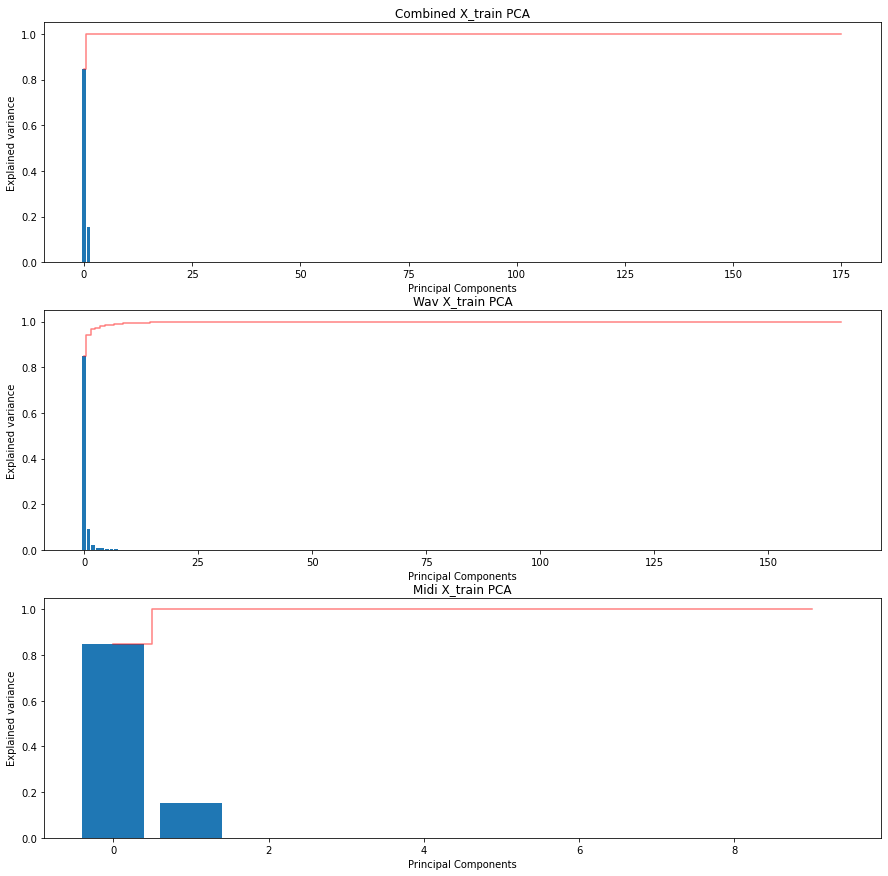

In [40]:
pca_c = PCA()
pca_c.fit_transform(X_train_c)
pca_w = PCA()
pca_w.fit_transform(X_train_w)
pca_m = PCA()
pca_m.fit_transform(X_train_m)
fig,ax = plt.subplots(3,1,figsize=(15,15))

explained_var_list_c = []  # holds explained variance values
cumulative_explained_variance_c = []
total = 0  # initialize total to 0
for i in pca_c.explained_variance_ratio_:  # iterate over explaiend variance ratios
    total += i  # sum total variance 
    cumulative_explained_variance_c.append(total)
    
explained_var_list_w = []  # holds explained variance values
cumulative_explained_variance_w = []
total = 0  # initialize total to 0
for i in pca_w.explained_variance_ratio_:  # iterate over explaiend variance ratios
    total += i  # sum total variance 
    cumulative_explained_variance_w.append(total) 

explained_var_list_m = []  # holds explained variance values
cumulative_explained_variance_m = []
total = 0  # initialize total to 0
for i in pca_m.explained_variance_ratio_:  # iterate over explaiend variance ratios
    total += i  # sum total variance 
    cumulative_explained_variance_m.append(total)     
    
ax[0].bar(x=range(176),
        height = pca_c.explained_variance_ratio_,
        alpha = 1, align='center', 
        label='Individual Explained Variance')
ax[0].step(x=range(176),
       y=cumulative_explained_variance_c,
       alpha=0.5,
       where='mid',
       color='red',
       label='Total Explained Variance')
ax[0].set_xlabel('Principal Components')
ax[0].set_ylabel('Explained variance')
ax[0].set_title('Combined X_train PCA')

ax[1].bar(x=range(167),
        height = pca_w.explained_variance_ratio_,
        alpha = 1, align='center', 
        label='Individual Explained Variance')
ax[1].step(x=range(167),
       y=cumulative_explained_variance_w,
       alpha=0.5,
       where='mid',
       color='red',
       label='Total Explained Variance')
ax[1].set_xlabel('Principal Components')
ax[1].set_ylabel('Explained variance')
ax[1].set_title('Wav X_train PCA')

ax[2].bar(x=range(10),
        height = pca_m.explained_variance_ratio_,
        alpha = 1, align='center', 
        label='Individual Explained Variance')
ax[2].step(x=range(10),
       y=cumulative_explained_variance_m,
       alpha=0.5,
       where='mid',
       color='red',
       label='Total Explained Variance')
ax[2].set_xlabel('Principal Components')
ax[2].set_ylabel('Explained variance')
ax[2].set_title('Midi X_train PCA')

In [43]:
X_train_c.shape

(263, 176)

In [41]:
import tensorflow as tf

In [66]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(176, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(21)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X_train_c, y_train_c, epochs=200)

Epoch 1/200
9/9 [==============================] - 0s 2ms/step - loss: 2561.7588 - accuracy: 0.3346
Epoch 2/200
9/9 [==============================] - 0s 2ms/step - loss: 447.4761 - accuracy: 0.5856
Epoch 3/200
9/9 [==============================] - 0s 2ms/step - loss: 302.7360 - accuracy: 0.5019
Epoch 4/200
9/9 [==============================] - 0s 2ms/step - loss: 192.1131 - accuracy: 0.6578
Epoch 5/200
9/9 [==============================] - 0s 2ms/step - loss: 105.5790 - accuracy: 0.5856
Epoch 6/200
9/9 [==============================] - 0s 1ms/step - loss: 173.4297 - accuracy: 0.5475
Epoch 7/200
9/9 [==============================] - 0s 3ms/step - loss: 145.0475 - accuracy: 0.5817
Epoch 8/200
9/9 [==============================] - 0s 2ms/step - loss: 130.8073 - accuracy: 0.5361
Epoch 9/200
9/9 [==============================] - 0s 2ms/step - loss: 124.2507 - accuracy: 0.6502
Epoch 10/200
9/9 [==============================] - 0s 2ms/step - loss: 97.6180 - accuracy: 0.5817
Epoch 11/

9/9 [==============================] - 0s 2ms/step - loss: 4.0544 - accuracy: 0.6806
Epoch 85/200
9/9 [==============================] - 0s 1ms/step - loss: 3.9513 - accuracy: 0.6654
Epoch 86/200
9/9 [==============================] - 0s 2ms/step - loss: 4.4559 - accuracy: 0.7072
Epoch 87/200
9/9 [==============================] - 0s 1ms/step - loss: 4.0670 - accuracy: 0.5551
Epoch 88/200
9/9 [==============================] - 0s 1ms/step - loss: 5.7505 - accuracy: 0.6806
Epoch 89/200
9/9 [==============================] - 0s 1ms/step - loss: 4.8507 - accuracy: 0.6578
Epoch 90/200
9/9 [==============================] - 0s 1ms/step - loss: 3.7808 - accuracy: 0.7034
Epoch 91/200
9/9 [==============================] - 0s 1ms/step - loss: 3.8281 - accuracy: 0.6046
Epoch 92/200
9/9 [==============================] - 0s 1ms/step - loss: 6.4146 - accuracy: 0.6160
Epoch 93/200
9/9 [==============================] - 0s 1ms/step - loss: 4.4577 - accuracy: 0.6616
Epoch 94/200
9/9 [===============

9/9 [==============================] - 0s 1ms/step - loss: 3.4410 - accuracy: 0.6844
Epoch 167/200
9/9 [==============================] - 0s 1ms/step - loss: 2.5394 - accuracy: 0.6502
Epoch 168/200
9/9 [==============================] - 0s 1ms/step - loss: 2.7315 - accuracy: 0.6958
Epoch 169/200
9/9 [==============================] - 0s 1ms/step - loss: 2.3369 - accuracy: 0.7072
Epoch 170/200
9/9 [==============================] - 0s 1ms/step - loss: 1.6479 - accuracy: 0.7072
Epoch 171/200
9/9 [==============================] - 0s 2ms/step - loss: 2.1728 - accuracy: 0.6578
Epoch 172/200
9/9 [==============================] - 0s 2ms/step - loss: 1.6091 - accuracy: 0.6920
Epoch 173/200
9/9 [==============================] - 0s 1ms/step - loss: 1.7122 - accuracy: 0.7072
Epoch 174/200
9/9 [==============================] - ETA: 0s - loss: 2.1566 - accuracy: 0.75 - 0s 2ms/step - loss: 1.7671 - accuracy: 0.7300
Epoch 175/200
9/9 [==============================] - 0s 2ms/step - loss: 1.5198 -

Epoch 1/200
9/9 [==============================] - 1s 2ms/step - loss: 7.9968 - accuracy: 0.0951 
Epoch 2/200
9/9 [==============================] - 0s 2ms/step - loss: 2.3727 - accuracy: 0.4487
Epoch 3/200
9/9 [==============================] - 0s 3ms/step - loss: 1.9996 - accuracy: 0.4829
Epoch 4/200
9/9 [==============================] - 0s 3ms/step - loss: 1.7401 - accuracy: 0.4867
Epoch 5/200
9/9 [==============================] - 0s 3ms/step - loss: 1.5692 - accuracy: 0.5209
Epoch 6/200
9/9 [==============================] - 0s 3ms/step - loss: 1.4707 - accuracy: 0.6464
Epoch 7/200
9/9 [==============================] - 0s 3ms/step - loss: 1.3402 - accuracy: 0.6578
Epoch 8/200
9/9 [==============================] - 0s 4ms/step - loss: 1.2739 - accuracy: 0.6616
Epoch 9/200
9/9 [==============================] - 0s 3ms/step - loss: 1.1545 - accuracy: 0.7186
Epoch 10/200
9/9 [==============================] - 0s 4ms/step - loss: 1.0365 - accuracy: 0.7262
Epoch 11/200
9/9 [==========

9/9 [==============================] - 0s 3ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 85/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 86/200
9/9 [==============================] - 0s 3ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 87/200
9/9 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 88/200
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 89/200
9/9 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 90/200
9/9 [==============================] - 0s 3ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 91/200
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 92/200
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 93/200
9/9 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 94/200
9/9 [===============

9/9 [==============================] - 0s 2ms/step - loss: 4.6497e-04 - accuracy: 1.0000
Epoch 166/200
9/9 [==============================] - 0s 2ms/step - loss: 4.5746e-04 - accuracy: 1.0000
Epoch 167/200
9/9 [==============================] - 0s 2ms/step - loss: 4.5693e-04 - accuracy: 1.0000
Epoch 168/200
9/9 [==============================] - 0s 2ms/step - loss: 4.4386e-04 - accuracy: 1.0000
Epoch 169/200
9/9 [==============================] - 0s 2ms/step - loss: 4.5392e-04 - accuracy: 1.0000
Epoch 170/200
9/9 [==============================] - 0s 2ms/step - loss: 4.5224e-04 - accuracy: 1.0000
Epoch 171/200
9/9 [==============================] - 0s 2ms/step - loss: 4.4529e-04 - accuracy: 1.0000
Epoch 172/200
9/9 [==============================] - 0s 2ms/step - loss: 4.3158e-04 - accuracy: 1.0000
Epoch 173/200
9/9 [==============================] - 0s 2ms/step - loss: 4.3357e-04 - accuracy: 1.0000
Epoch 174/200
9/9 [==============================] - 0s 2ms/step - loss: 4.1372e-04 - a

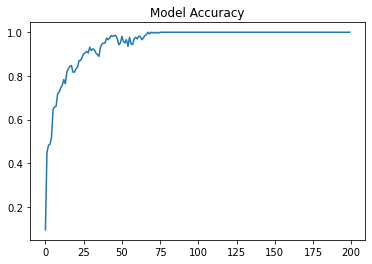

In [70]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(176, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(21)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(X_train_w, y_train_w, epochs=200)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
pass

In [68]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(176, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(21)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X_train_m, y_train_m, epochs=200)

Epoch 1/200
9/9 [==============================] - 1s 2ms/step - loss: 2009.8451 - accuracy: 0.4753
Epoch 2/200
9/9 [==============================] - 0s 3ms/step - loss: 642.1338 - accuracy: 0.4753
Epoch 3/200
9/9 [==============================] - 0s 2ms/step - loss: 464.7596 - accuracy: 0.6160
Epoch 4/200
9/9 [==============================] - 0s 3ms/step - loss: 245.5112 - accuracy: 0.5247
Epoch 5/200
9/9 [==============================] - 0s 4ms/step - loss: 212.8921 - accuracy: 0.6388
Epoch 6/200
9/9 [==============================] - 0s 3ms/step - loss: 166.1988 - accuracy: 0.5475
Epoch 7/200
9/9 [==============================] - 0s 3ms/step - loss: 119.9935 - accuracy: 0.6198
Epoch 8/200
9/9 [==============================] - 0s 4ms/step - loss: 89.2880 - accuracy: 0.6160
Epoch 9/200
9/9 [==============================] - 0s 2ms/step - loss: 86.1002 - accuracy: 0.6160
Epoch 10/200
9/9 [==============================] - 0s 6ms/step - loss: 135.7394 - accuracy: 0.6502
Epoch 11/2

9/9 [==============================] - 0s 5ms/step - loss: 9.3472 - accuracy: 0.6198
Epoch 83/200
9/9 [==============================] - 0s 6ms/step - loss: 10.7958 - accuracy: 0.6768
Epoch 84/200
9/9 [==============================] - 0s 4ms/step - loss: 8.0447 - accuracy: 0.6578
Epoch 85/200
9/9 [==============================] - 0s 3ms/step - loss: 7.7561 - accuracy: 0.6236
Epoch 86/200
9/9 [==============================] - 0s 3ms/step - loss: 5.0111 - accuracy: 0.6730
Epoch 87/200
9/9 [==============================] - 0s 3ms/step - loss: 4.9513 - accuracy: 0.6350
Epoch 88/200
9/9 [==============================] - 0s 3ms/step - loss: 3.1736 - accuracy: 0.6616
Epoch 89/200
9/9 [==============================] - 0s 3ms/step - loss: 4.8409 - accuracy: 0.6464
Epoch 90/200
9/9 [==============================] - 0s 2ms/step - loss: 4.5584 - accuracy: 0.6768
Epoch 91/200
9/9 [==============================] - 0s 2ms/step - loss: 4.8248 - accuracy: 0.6008
Epoch 92/200
9/9 [==============

9/9 [==============================] - 0s 2ms/step - loss: 3.8424 - accuracy: 0.6768
Epoch 165/200
9/9 [==============================] - 0s 2ms/step - loss: 3.5698 - accuracy: 0.6882
Epoch 166/200
9/9 [==============================] - 0s 2ms/step - loss: 2.3820 - accuracy: 0.6654
Epoch 167/200
9/9 [==============================] - 0s 2ms/step - loss: 2.5646 - accuracy: 0.7262
Epoch 168/200
9/9 [==============================] - 0s 2ms/step - loss: 4.2211 - accuracy: 0.5209
Epoch 169/200
9/9 [==============================] - 0s 2ms/step - loss: 9.9665 - accuracy: 0.6350
Epoch 170/200
9/9 [==============================] - 0s 2ms/step - loss: 7.3482 - accuracy: 0.6730
Epoch 171/200
9/9 [==============================] - 0s 2ms/step - loss: 4.2953 - accuracy: 0.6958
Epoch 172/200
9/9 [==============================] - 0s 3ms/step - loss: 3.8475 - accuracy: 0.6844
Epoch 173/200
9/9 [==============================] - 0s 2ms/step - loss: 4.1760 - accuracy: 0.6502
Epoch 174/200
9/9 [=====